In [29]:
import numpy as np
import random, math
from scipy.optimize import minimize 
import matplotlib.pyplot as plt

In [30]:
# # Generate test data
# # Use random.randn to generate arrays with random numbers 
# # mean=0,var=1

# np.random.seed(100)

# classA = np.concatenate((np.random.randn(10,2)*0.2+[1.5,0.5],
#                             np.random.randn(10,2)*0.2+[-1.5,0.5]))

# classB = np.random.randn(10,2)*(0.2)+[0.0,-0.5]

# inputs = np.concatenate((classA,classB)) 
# targets = np.concatenate((np.ones(classA.shape[0]) , 
#                             -np.ones(classB.shape[0])))

# N = inputs.shape[0] # Number of rows (samples)


In [31]:
np.random.seed(1)
random.seed = 1
epsilon = 1e-5

In [32]:
class SVM():
    def __init__(self, C = 100, kernel = "linear", kernel_param = 2):
        self.C = C
        self.kernel = kernel
        self.kernel_param = kernel_param

    # KERNELS
    def __kernel(self, x, y):
        if self.kernel == "linear":
            return self.__kernel_linear(x, y)
        if self.kernel == "poly":
            return self.__kernel_poly(x, y)
        if self.kernel == "rbf":
            return self.__kernel_rbf(x, y)

    def __kernel_linear(self, x, y):
        return np.dot(np.transpose(x), y)

    def __kernel_poly(self, x, y):
        return (np.dot(np.transpose(x), y) + 1) ** self.kernel_param

    def __kernel_rbf(self, x, y):
        return math.exp(-((np.linalg.norm(x - y)) ** 2\
            / (2 * self.kernel_param ** 2)))

    # PROBLEM DEFINITION
    def __compute_P_mat(self, t, xs):
        P = np.zeros((len(xs), len(xs)))
        for i in range(len(xs)):
            for j in range(len(xs)):
                P[i][j] = t[i]*t[j]*self.__kernel(xs[i], xs[j])
        return P

    def __objective(self, alpha):
        return 0.5*np.dot(np.dot(np.transpose(alpha), self.P), alpha) - np.sum(alpha)

    def __zerofun(self, alpha):
        return np.dot(np.transpose(alpha), self.targets)

    # AFTER MINIMIZATION
    def __compute_b(self):
        support_vector = self.non_zero_vals[0][1]
        t_support = self.non_zero_vals[0][2]
        for alpha, x, t in self.non_zero_vals:
            if alpha < self.C:
                t_support = t
                support_vector = x

        if t_support == 0:
            print("ERROR: Couldn't find alpha < C")
            return 0

        b_result = 0
        for alpha, x, t in self.non_zero_vals:
            b_result += alpha*t*self.__kernel(support_vector, x)
        return b_result - t_support

    # PUBLIC:
    def train(self, classA, classB):
        inputs = np.concatenate((classA , classB))  # x and y coordinates for the data
        targets = np.concatenate((np.ones(classA.shape[0]), -np.ones(classB.shape[0])))  # holds the +1 or -1 values for the inputs, their indices in the list coincide respectively
        self.n_train = inputs.shape[0]  # Number of samples
        permute = list(range(self.n_train))
        random.shuffle(permute)
        self.inputs = inputs[permute, : ]  # Training values
        self.targets = targets[permute]  # Training labels

        self.P = self.__compute_P_mat(self.targets, self.inputs)
        alpha_0 = np.zeros(self.n_train)
        bounds = [(0, self.C) for b in range(self.n_train)]
        constraint = {'type':'eq', 'fun':self.__zerofun}

        print("Training...")
        ret = minimize(self.__objective, alpha_0, bounds = bounds, constraints = constraint)
    
        alpha = ret.x
        if ret.success:
            print("Success")
        else:
            print("ERROR: Optimization didnt converge")
            return

        # Remove 0's
        self.non_zero_vals = []
        for i in range(len(alpha)):
            if alpha[i] > epsilon:
                self.non_zero_vals.append((alpha[i], self.inputs[i], self.targets[i]))

        # Compute b
        self.b = self.__compute_b()

    def indicator(self, point):
        sumation = 0
        for alpha, x, t in self.non_zero_vals:
            sumation += alpha*t*self.__kernel(point, x)
        return sumation - self.b

    def plot(self, classA, classB):
        plt.plot( [ p[0] for p in classA], [ p[1] for p in classA], 'b. ' )
        plt.plot( [ p[0] for p in classB], [ p[1] for p in classB], 'r. ' )

        xgrid = np.linspace(-5, 5)
        ygrid = np.linspace(-4, 4)
        grid = np.array([[self.indicator(np.array((x,y)))
                            for x in xgrid]
                            for y in ygrid])

        plt.contour(xgrid, ygrid, grid, (-1.0, 0.0, 1.0),
                    colors = ("red", "black", "blue"),
                    linewidths = (1, 3, 1))

        plt.axis('equal')           # Force same scale on both axes
        plt.savefig('svmplot.png')  # Save a copy in a file
        plt .show()                 # Show the plot on the screen


Training...
Success


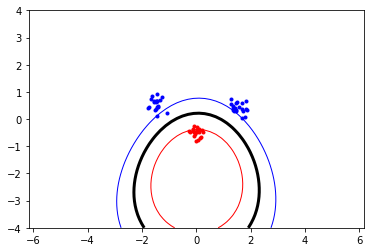

In [33]:
if __name__ == "__main__":
    # Create dataset
    classA = np.concatenate((\
            np.random.randn(20, 2) * 0.2 + [1.5,0.5],\
            np.random.randn(20, 2) * 0.2 + [-1.5,0.5]))
    classB = np.random.randn(20, 2) * 0.2 + [0.0, -0.5]
    
    #svm = SVM(C = 1, kernel = "linear", kernel_param = 0)
    #svm = SVM(C = 1, kernel = "poly", kernel_param = 2)
    svm = SVM(C = 10, kernel = "rbf", kernel_param = 3)
    svm.train(classA, classB)
    svm.plot(classA, classB)

    
